# imports

In [8]:
import pandas as pd
import numpy as np
import math
import datetime
import seaborn as sns
import xgboost as xgb
import random
import warnings
import pickle
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## helper functions

In [9]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     sns.set()
# jupyter_settings()

# load data

In [10]:
data_store = pd.read_csv('../data/rossmann-store-sales/store.csv',low_memory=False)
data_test = pd.read_csv('../data/rossmann-store-sales/test.csv',low_memory=False)

In [11]:
data_test['Date'] = pd.to_datetime(data_test['Date'])

# Rossmann Class

In [6]:
import inflection
import pickle
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    
    def __init__(self):
        self.home_path = 'Users/Lavin/Documents/Comunidade DS/Ds_em_producao'
        self.competition_distance_scaler    = pickle.load(open(self.home_path + 'parameter/rescaling_competition_distance.pkl','rb'))
        self.competition_time_month_scaler  = pickle.load(open(self.home_path + 'parameter/rescaling_competition_time_month.pkl','rb'))
        self.promo_time_week_scaler         = pickle.load(open(self.home_path + 'parameter/rescaling_promo_time_week.pkl','rb'))
        self.year_scaler                    = pickle.load(open(self.home_path + 'parameter/rescaling_year.pkl','rb'))
        self.store_type_encoder             = pickle.load(open(self.home_path + 'parameter/encoding_store_type.pkl','rb'))

       
        
        state=1
    def data_cleaning(self,df1):
    

        
        old_cols = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        new_cols = list(map(snakecase,old_cols))
        df1.columns = new_cols
        
        df1['date'] = pd.to_datetime(df1['date'])
        
        dist = lambda x: 200000.0 if math.isnan(x) else x
        df1['competition_distance'] = df1['competition_distance'].apply(dist)

        # competition_open_since_month   
        comp_op_sin_mon = lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
        df1['competition_open_since_month'] = df1.apply(comp_op_sin_mon,axis=1)
        # competition_open_since_year    
        comp_op_sin_year = lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
        df1['competition_open_since_year'] = df1.apply(comp_op_sin_year,axis=1)

        # promo2                         
        # promo2_since_week
        prom_week = lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week']
        df1['promo2_since_week'] = df1.apply(prom_week,axis=1)

        # promo2_since_year       
        prom_year = lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year']
        df1['promo2_since_year'] = df1.apply(prom_year,axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov',12:'Dec'}
        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map'] = df1['date'].dt.month.replace(month_map)
        prom_int = lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(prom_int,axis=1)
        
        # change types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self,df2):
        #year
        df2['year'] = df2['date'].dt.year
        #month
        df2['month'] = df2['date'].dt.month
        #day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%m')

        # competiiton since
        comp_sinc = lambda x: datetime.datetime(year=x['competition_open_since_year'],month = x['competition_open_since_month'],day=1)
        df2['competition_since'] = df2.apply(comp_sinc,axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
  
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str)+ '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        assrt = {'a':'basic','b':'extra','c':'extended'}
        df2['assortment']= df2['assortment'].replace(assrt)
        
        # state_holiday
        sta_hol = { 'a':'public_holiday', 'b':'easter_holiday', 'c': 'christmas', '0':'regular_day'}
        df2['state_holiday'] = df2['state_holiday'].replace(sta_hol)
        
        # season
        winter_month = [12,1,2]
        spring_month = [3,4,5]
        summer_month = [6,7,8]
        fall_month = [9,10,11]
        df2['season'] = df2['month'].apply(lambda x: 'winter' if  x in winter_month else 
                                          ('spring' if x in spring_month else
                                           ('summer' if x in summer_month else
                                            ('fall' if x in fall_month else 'NA'))))
        # filtering rows
        
        #filtering colums
        cols_drop = ['open','promo_interval', 'month_map']
        df2.drop(columns=cols_drop,inplace=True)
        
        return df2
    
    def data_preparation(self,df5):
        
        #rescaling ==========================================================
        
        # competiton distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        # competiton time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
        
        df5['year'] = self.year_scaler.transform(df5[['year']].values)
        
        
        #encodig =============================================================
        
        # state_holiday - one hot encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])
        # store_type - label encoding
        df5['store_type'] = self.store_type_encoder.transform(df5['store_type'])
        
        # assortment - ordinal encoding
        assortment_dict = {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        # season - one hot encoding
        df5 = pd.get_dummies(df5,prefix=['season'],columns=['season'])
        
          
        # nature transform ==================================================
        
        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.* np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.* np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.* np.pi/31)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.* np.pi/31)))

        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.* np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.* np.pi/52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.* np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.* np.pi/7)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                       'competition_open_since_month', 'competition_open_since_year', 'promo2',
                       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                       'promo_time_week', 'competition_ time_month', 'month_sin','month_cos', 'day_sin',
                       'day_cos','week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']
        return df5[cols_selected]
    
    def get_prediction(self,model,original_data,test_data):
        #prediction
        
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records',date_format='iso')

# API Handler

In [7]:
import pandas as pd
from flask import Flask, request, Response
#from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open(r'C:/Users/Lavin/Documents/Comunidade DS/Ds_em_producao/model/model_rossman_xgb.pkl'))

app = Flask(__name__)

@app.route('/rossmann/predict',methods=['POST'])
def rossmann_predict():
    test_json = request.get_jason()
    
    if test_json: #there is data
        
        if isinstance(test_json,dict): #UNique example
            test_raw = pd.DataFrame(test_json,index=[0])
        else: # Multiple Examples
            test_raw = pd.DataFrame(test_json,columns=test_json[0].keys())
        
        # Instantiate Rossman class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature engeneering
        df2 = pipeline.feature_engineering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)
        # prediction
        df_response = pipeline.get_prediction(model,test_raw,df3)
        
        return df_response
    
    else:
        return Response('{}',status=200,mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 47: character maps to <undefined>

# API test

In [12]:
import requests
import json

In [13]:
df_test = pd.merge(data_test,data_store,how='left',on='Store')

#choose store for prediction
df_test = df_test[df_test['Store']==22]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test.drop('Id',axis=1,inplace=True)
df_test['Date'] = df_test['Date'].astype(str)

In [14]:
# convert dataframe to json
data = df_test.to_dict(orient='records')
data = json.dumps(data)

In [15]:
# Api call

url = 'http://192.168.0.5:5000/rossmann/predict'
#url = 'https://rossmann-predict-lav-test.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url,data,headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [16]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())
#d1 = d1[['store','prediction']].groupby('store').sum().reset_index()

<AxesSubplot:xlabel='week_of_year', ylabel='prediction'>

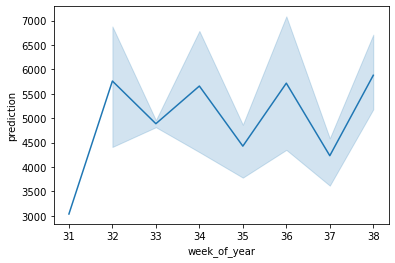

In [17]:
sns.lineplot(x='week_of_year',y='prediction',data=d1)

In [18]:
print("Store number {} will sell R$ {:,.2f} in the next 6 weeks".format(d1.loc[0,'store'],d1.loc[0,'prediction']))

Store number 22 will sell R$ 5,128.81 in the next 6 weeks
